In [4]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [10]:
path = os.getcwd()
abspath = os.path.abspath(os.path.join(path, os.pardir))

print(abspath)

/tf/src


In [12]:
directory = f"{abspath}/NewMaskODM/masks/Medical mask/Medical mask/Medical Mask/annotations"
OC_Net = cv2.dnn.readNetFromCaffe(f"{abspath}/NewMaskODM/caffe/architecture.txt", f'{abspath}/NewMaskODM/caffe/weights.caffemodel')
df = pd.read_csv(f"{abspath}/NewMaskODM/masks/train.csv")
df_test = pd.read_csv(f"{abspath}/NewMaskODM/masks/submission.csv")
image_directory = f"{abspath}/NewMaskODM/masks/Medical mask/Medical mask/Medical Mask/images"
image_test_directory = ".../input/pictest1/"
# 1. Importing face-mask-detection-dataset dataset, The Annotations field contains the data of all the faces present in a particular image. 
df.head(10)

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
5,6427.png,218,98,577,580,face_with_mask_incorrect
6,6427.png,278,386,582,582,mask_surgical
7,4591.png,239,9,522,342,face_with_mask
8,4591.png,255,159,491,341,mask_colorful
9,5392.jpg,261,0,444,257,face_other_covering


In [66]:
data = []
img_size = 224
mask_describe = ['face_with_mask',"face_no_mask"]
labels={'mask':0,'without mask':1}
type_mask = []
fileste= ".json"

def get_bounding(j,i,data,labels_item):
    x,y,w,h = j["BoundingBox"]
    img = cv2.imread(os.path.join(image_directory,i),1)
    img = img[y:h,x:w]
    img = cv2.resize(img,(img_size,img_size))
    data.append([img,labels_item])
    
def get_json_file(PathName):
    with open(PathName,'r') as f:
        return json.load(f)

for i in df["name"].unique():
    f = i+fileste
    for j in get_json_file(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask_describe[0]:
            get_bounding(j,i,data,labels['mask'])
            type_mask.append(labels['mask'])
            
        if j["classname"] in mask_describe[1]:
            get_bounding(j,i,data,labels['without mask'])
            type_mask.append(labels['without mask'])

random.shuffle(data)  

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

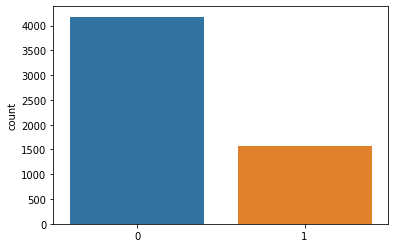

In [67]:
sns.countplot(type_mask)

In [68]:
features = []
labels = []
for f,l in data:
    features.append(f)
    labels.append(l)

In [69]:
features[0].shape

(224, 224, 3)

In [70]:
features = np.array(features)/255.0
features = features.reshape(-1,img_size,img_size,3)
labels = np.array(labels)

print(np.unique(labels))
print(features.shape)

[0 1]
(5749, 224, 224, 3)


In [71]:
from keras.applications.mobilenet_v2 import MobileNetV2

base_model_mobile = MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

for layer in base_model_mobile.layers:
    layer.trainable = False
    
model_mobile = Sequential()
model_mobile.add(base_model_mobile)
model_mobile.add(Flatten())
model_mobile.add(Dense(1,activation='sigmoid'))
model_mobile.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [72]:
train_f,val_f,train_l,val_l=train_test_split(features, labels,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(
        rotation_range= 17,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        #zca_epsilon = 1e-05, 
        horizontal_flip=True, 
        #rescale=1./255,
        shear_range=0.2,
        #zoom_range=0.1,
        #brightness_range = [0.1, 10], 
)
datagen.fit(train_f)

In [73]:
model_mobile.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

history_mobile = model_mobile.fit_generator(datagen.flow(train_f, train_l, batch_size=32),
                   steps_per_epoch=train_f.shape[0]//32,
                   epochs=10,
                   verbose=1,
                   validation_data=(val_f, val_l))


<ipython-input-73-1d0140af3eb5>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mobile = model_mobile.fit_generator(datagen.flow(train_f, train_l, batch_size=32),


Epoch 1/10
143/143 [==============================] - 35s 226ms/step - loss: 0.5277 - accuracy: 0.9137 - val_loss: 0.2550 - val_accuracy: 0.9591
Epoch 2/10
143/143 [==============================] - 33s 230ms/step - loss: 0.3838 - accuracy: 0.9407 - val_loss: 0.4961 - val_accuracy: 0.9287
Epoch 3/10
143/143 [==============================] - 22s 156ms/step - loss: 0.4371 - accuracy: 0.9431 - val_loss: 0.4203 - val_accuracy: 0.9426
Epoch 4/10
143/143 [==============================] - 22s 156ms/step - loss: 0.3170 - accuracy: 0.9565 - val_loss: 0.4667 - val_accuracy: 0.9513
Epoch 5/10
143/143 [==============================] - 22s 154ms/step - loss: 0.3201 - accuracy: 0.9553 - val_loss: 0.4543 - val_accuracy: 0.9487
Epoch 6/10
143/143 [==============================] - 22s 154ms/step - loss: 0.2649 - accuracy: 0.9643 - val_loss: 0.4838 - val_accuracy: 0.9504
Epoch 7/10
143/143 [==============================] - 22s 155ms/step - loss: 0.2612 - accuracy: 0.9658 - val_loss: 0.4397 - val_ac

In [74]:
history_list = []
history_list.append(history_mobile)

In [75]:
model_mobile.evaluate(val_f, val_l)
prediction_mobile = model_mobile.predict(val_f)

36/36 [==============================] - 1s 28ms/step - loss: 0.4752 - accuracy: 0.9643


In [77]:
model_mobile.save(f"{abspath}/NewMaskODM/models/v2/")

INFO:tensorflow:Assets written to: /tf/src/NewMaskODM/models/v2/assets


INFO:tensorflow:Assets written to: /tf/src/NewMaskODM/models/v2/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


AxesSubplot(0.125,0.125;0.775x0.755)


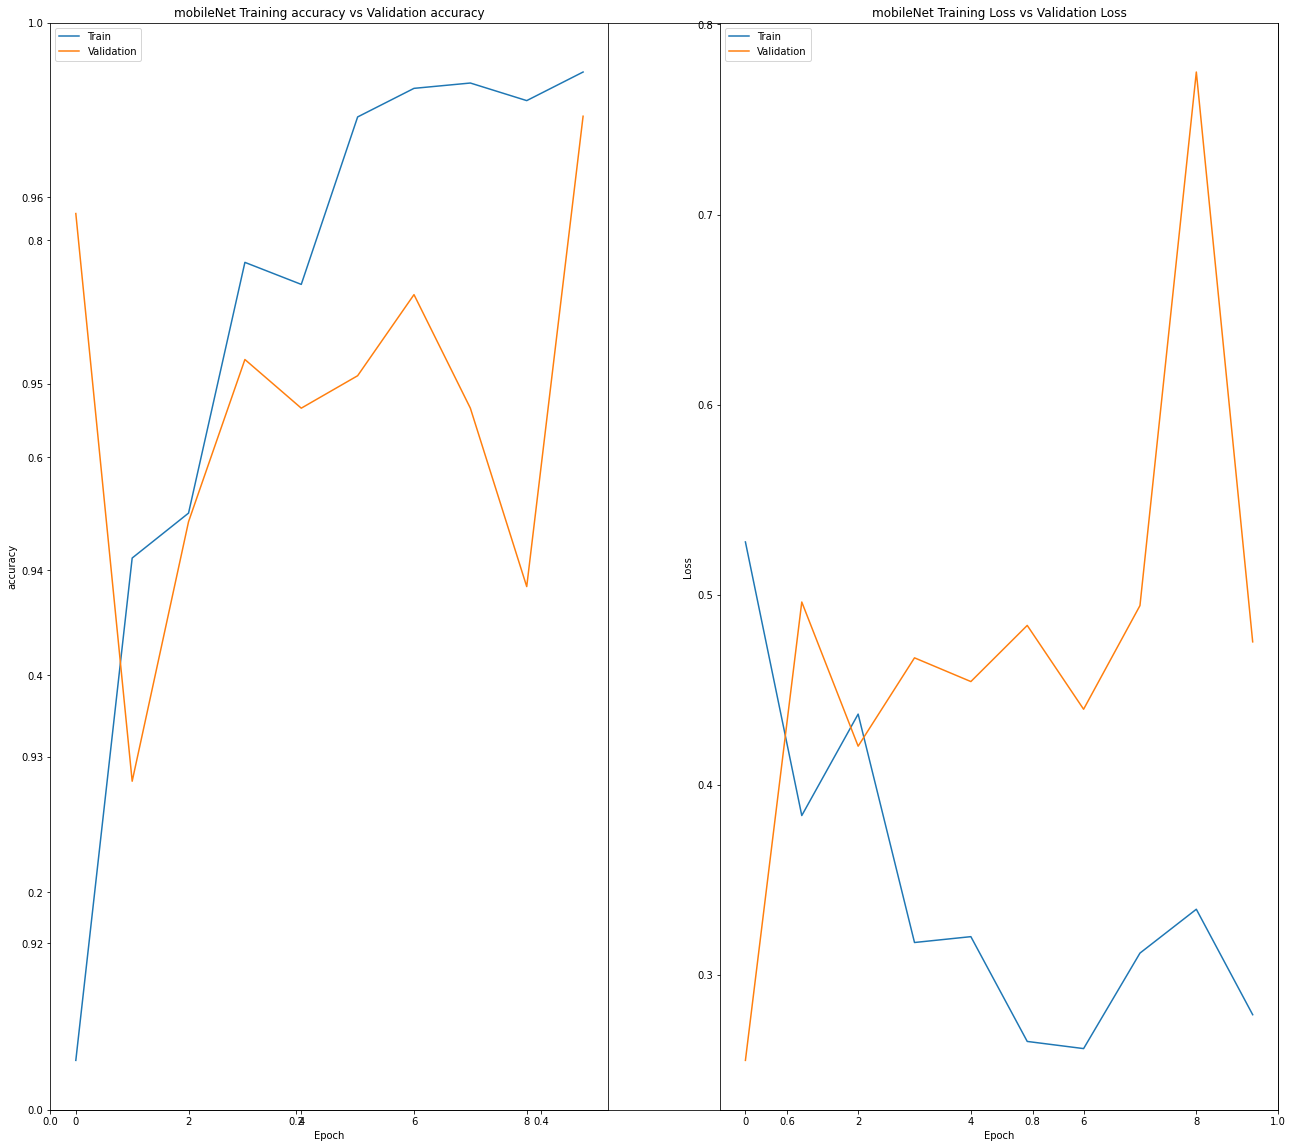

In [78]:
import numpy
import pandas 
import matplotlib.pyplot as plt
%matplotlib inline

#1 
fig,ax = plt.subplots(figsize=(22,20))

print(ax)
ax7 = fig.add_subplot(1,2,1)
ax8 = fig.add_subplot(1,2,2)

#3
ax7.plot(history_mobile.history['accuracy'])
ax7.plot(history_mobile.history['val_accuracy'])
ax7.set_title('mobileNet Training accuracy vs Validation accuracy')
ax7.set_ylabel('accuracy')
ax7.set_xlabel('Epoch')
ax7.legend(['Train', 'Validation'], loc='upper left')

ax8.plot(history_mobile.history['loss'])
ax8.plot(history_mobile.history['val_loss'])
ax8.set_title('mobileNet Training Loss vs Validation Loss')
ax8.set_ylabel('Loss')
ax8.set_xlabel('Epoch')
ax8.legend(['Train', 'Validation'], loc='upper left')

In [97]:
test_img = ["1136.jpg","0375.jpg","0919.jpg","1035.jpeg"]
image_test_directory = f"{abspath}/NewMaskODM/masks/Medical mask/Medical mask/Medical Mask/images/"


In [98]:
def extract_face(face):

    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def get_label(frame,img_size):
    im = cv2.resize(frame,(img_size,img_size))
    im = np.array(im)/255.0
    im = im.reshape(1,img_size,img_size,3)
    result = model.predict(im)
    label_Y=1 if result>0.3 else 0
    return label_Y,result

0 [[5.476781e-19]]
0 [[0.]]
0 [[0.]]
1 [[1.]]
1
0919.jpg
1 [[1.]]
1
1035.jpeg
0 [[1.8429964e-38]]


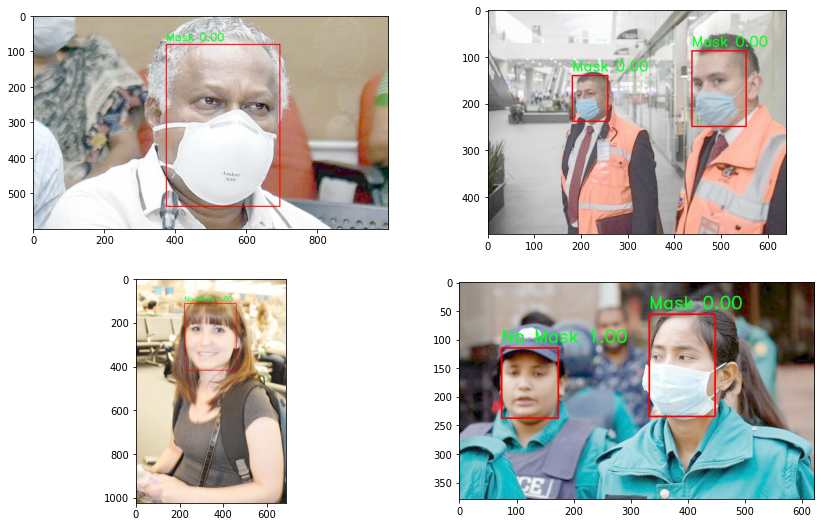

In [104]:
model = model_mobile

# adjust image darker and light 
adjust_light,rows,cols = 2.2,3,2
figure= plt.figure(figsize = (14,14))
axes = []
assign = {'0':'Mask','1':"No Mask"}
face_list = [] # save no mask

for j,im in enumerate(test_img):
    image =  cv2.imread(os.path.join(image_test_directory,im),1)
    back_image = image
    image = cv2.LUT(image.astype(np.uint8), np.array([((i / 255.0) ** (1.0 / adjust_light)) * 255 for i in np.arange(0, 256)]).astype(np.uint8))
    blob = cv2.dnn.blobFromImage(image=cv2.resize(image, (300,300)), scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
    
    OC_Net.setInput(blob)
    detections = OC_Net.forward()
    length = detections.shape[2]
    (hight, width) = image.shape[:2]
    for i in range(0, length):
        # get the face box
        boxs = detections[0, 0, i, 3:7] * np.array([width, hight, width, hight])
        (startX, startY, endX, endY) = boxs.astype("int")
        frame = image[startY:endY, startX:endX]
        
        # according to the confidence_threshold, to get the lable
        confidence_threshold = detections[0, 0, i, 2]
        if confidence_threshold > 0.4:
            label_Y,result = get_label(frame,img_size)
            print(label_Y,result)
           
            # add the Text
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image,assign[str(label_Y)] + "{: .2f}".format(float(result)) , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (36,255,12), 2)
            
            ## save nomask people mesage
            if(label_Y==1):
                print("1")
#                     plt.imshow(back_image)
                face_list.append(im)
                print(im)

    axes.append(figure.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()